In [ ]:
!pip install transformers datasets torch torchvision kaggle
!kaggle datasets download mahmudulhasantasin/fracatlas-original-dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Dataset URL: https://www.kaggle.com/datasets/mahmudulhasantasin/fracatlas-original-dataset
License(s): CC0-1.0
 99% 319M/323M [00:05<00:00, 39.1MB/s]
100% 323M/

In [ ]:
!unzip fracatlas-original-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: FracAtlas/Annotations/YOLO/IMG0003207.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003208.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003209.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003210.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003211.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003212.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003213.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003214.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003215.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003216.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003217.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003218.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003219.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003220.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003221.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003222.txt  
  inflating: FracAtlas/Annotations/YO

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.6/911.6 kB 23.5 MB/s eta 0:00:00


In [ ]:
import os
import json
import random


COCO_JSON = "/content/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json"
IMAGES_DIR = "/content/FracAtlas/images/Fractured"
OUTPUT_DIR = "yolo_labels"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load COCO data
with open(COCO_JSON, "r") as f:
    coco_data = json.load(f)

images_info = {img["id"]: img for img in coco_data["images"]}
annotations = coco_data["annotations"]
categories_info = coco_data.get("categories", [])


cat_ids = sorted(list({cat["id"] for cat in categories_info}))
catid2yolo = {cat_id: idx for idx, cat_id in enumerate(cat_ids)}

def coco_to_yolo_bbox(bbox, w, h):
    """
    Convert [x_min, y_min, width, height] in absolute float
    to [x_center, y_center, width, height] in relative coords.
    """
    x_min, y_min, bw, bh = bbox
    x_center = (x_min + bw / 2) / w
    y_center = (y_min + bh / 2) / h
    bw_rel = bw / w
    bh_rel = bh / h
    return (x_center, y_center, bw_rel, bh_rel)

# Process each annotation
for ann in annotations:
    img_id = ann["image_id"]
    cat_id = ann["category_id"]
    bbox = ann["bbox"]

    # Skip if image not found
    if img_id not in images_info:
        continue

    # Get image info
    img_info = images_info[img_id]
    img_w, img_h = img_info["width"], img_info["height"]
    # YOLO class index
    yolo_class_id = catid2yolo[cat_id]

    # Convert bbox
    x_center, y_center, bw, bh = coco_to_yolo_bbox(bbox, img_w, img_h)

    # Prepare line
    label_str = f"{yolo_class_id} {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}\n"

    # Derive output file name from image file_name
    base_name = os.path.splitext(img_info["file_name"])[0]
    out_path = os.path.join(OUTPUT_DIR, base_name + ".txt")

    # Append to file (so multiple bboxes per image go in the same file)
    with open(out_path, "a") as f_out:
        f_out.write(label_str)

print(f"Conversion complete. YOLO labels saved in: {OUTPUT_DIR}")

# ============ Step 2: Spot check / verify some labels ============

# We'll just read a random .txt file from OUTPUT_DIR and print
label_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith(".txt")]
if label_files:
    sample_file = random.choice(label_files)
    print(f"\nRandom spot check for file: {sample_file}")
    with open(os.path.join(OUTPUT_DIR, sample_file), "r") as f_in:
        lines = f_in.readlines()
    print("Contents:")
    for line in lines:
        print(line.strip())


Conversion complete. YOLO labels saved in: yolo_labels

Random spot check for file: IMG0002572.txt
Contents:
0 0.103949 0.226787 0.050006 0.115037
0 0.197961 0.585867 0.032004 0.069022
0 0.140953 0.520131 0.022003 0.118324
0 0.711527 0.547658 0.067009 0.068200
0 0.690525 0.187346 0.037005 0.034511


In [ ]:
import os
import random
import shutil

IMAGES_DIR = "/content/FracAtlas/images/Fractured"
LABELS_DIR = "/content/yolo_labels"

OUTPUT_DIR = "dataset"  # we'll create dataset/images/train, dataset/images/val, dataset/labels/train, dataset/labels/val
TRAIN_RATIO = 0.8       # 80% for training, 20% for validation

# Create the subfolders
os.makedirs(os.path.join(OUTPUT_DIR, "images/train"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "images/val"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "labels/train"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "labels/val"), exist_ok=True)

# List all images
all_images = [f for f in os.listdir(IMAGES_DIR)
              if f.lower().endswith((".jpg", ".png", ".jpeg", ".bmp"))]

random.shuffle(all_images)

# Calculate split index
train_count = int(len(all_images) * TRAIN_RATIO)
train_images = all_images[:train_count]
val_images = all_images[train_count:]

def move_files(image_list, subset_name):
    for img_file in image_list:
        # Source image path
        src_img_path = os.path.join(IMAGES_DIR, img_file)
        # Destination image path
        dst_img_path = os.path.join(OUTPUT_DIR, f"images/{subset_name}", img_file)

        # Move (or copy) the image
        shutil.copy2(src_img_path, dst_img_path)

        # Now handle the label file
        base_name = os.path.splitext(img_file)[0]
        label_file = base_name + ".txt"
        src_label_path = os.path.join(LABELS_DIR, label_file)
        dst_label_path = os.path.join(OUTPUT_DIR, f"labels/{subset_name}", label_file)

        # If a label file exists, copy it
        if os.path.exists(src_label_path):
            shutil.copy2(src_label_path, dst_label_path)

# Move/copy images to train folder
move_files(train_images, "train")

# Move/copy images to val folder
move_files(val_images, "val")

print("Dataset split completed!")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")


Dataset split completed!
Training images: 573
Validation images: 144


In [ ]:


%%writefile datafrac_v8.yaml
path: '/content/dataset'
train: '/content/dataset/images/train'
val: '/content/dataset/images/val'
#class names

names :
  0: fracture



Writing datafrac_v8.yaml


YOLOV8n Training

In [ ]:
EPOCHS = 80
BATCH = 8
IMG_SIZE=1280

In [ ]:
!yolo \
task =detect \
mode =train \
model =yolov8n.pt \
imgsz ={IMG_SIZE} \
data =datafrac_v8.yaml \
epochs ={EPOCHS} \
batch ={BATCH} \
name = yolov8n_50e






Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 6.25M/6.25M [00:00<00:00, 91.5MB/s]
Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datafrac_v8.yaml, epochs=80, time=None, patience=100, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_50e, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybri

In [ ]:
save_dir="/content/drive/MyDrive/Colab_Notebooks/Trained_Models"

Reference Images

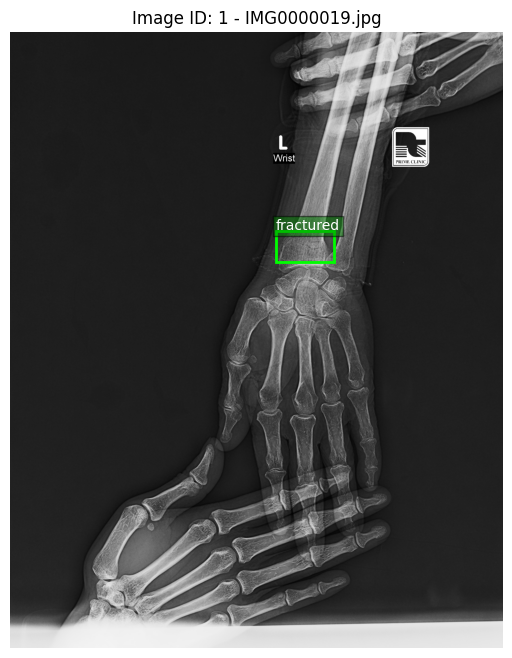

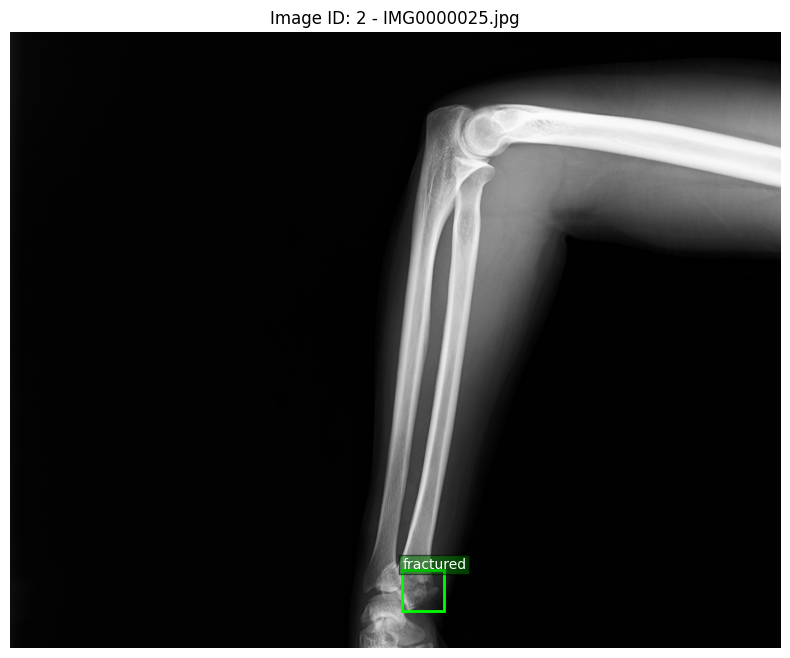

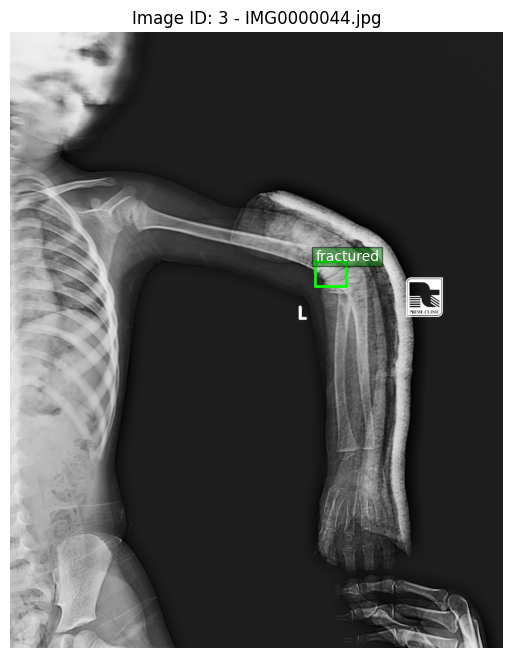

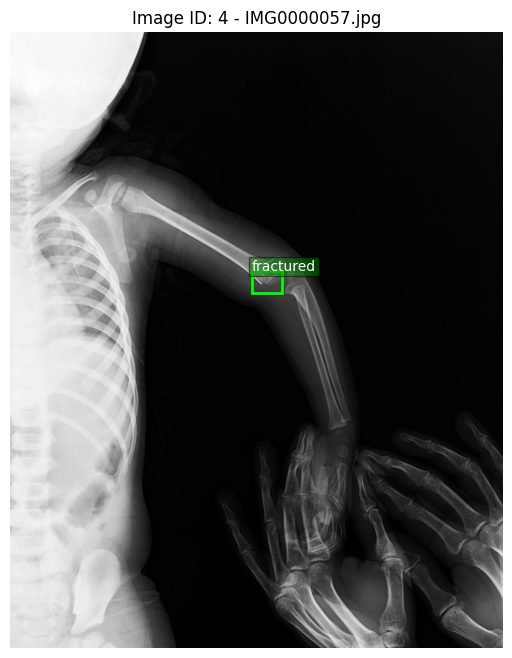

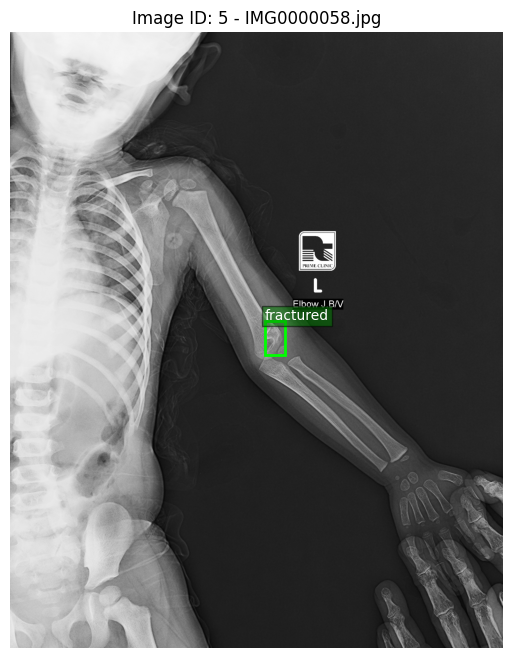

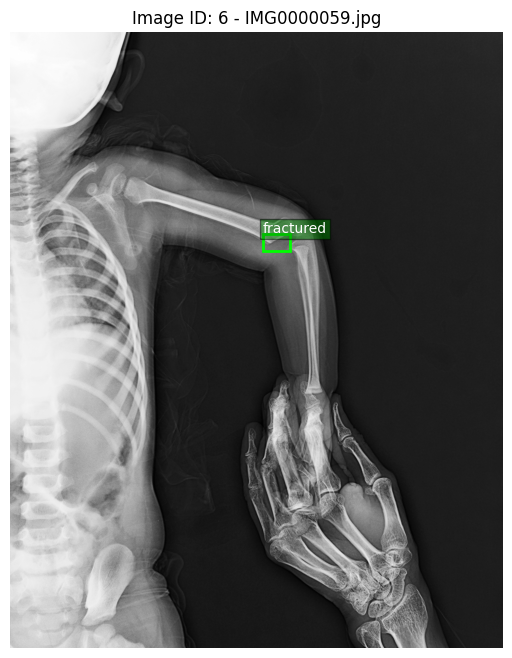

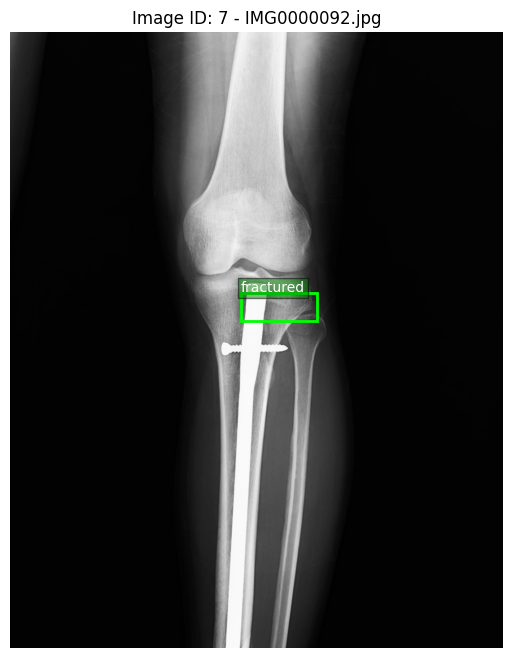

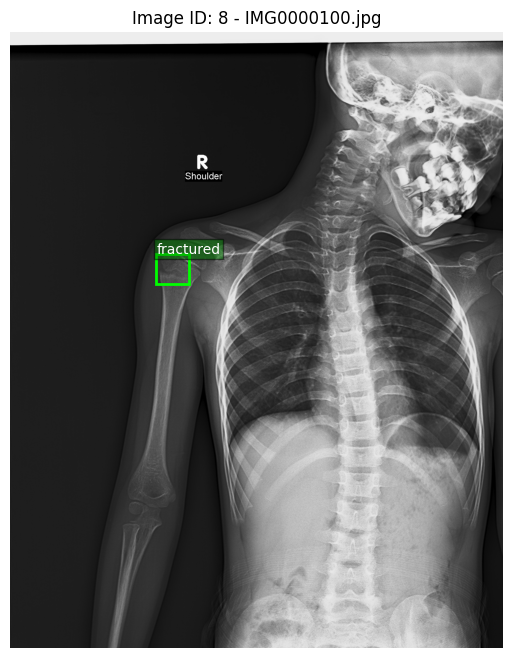

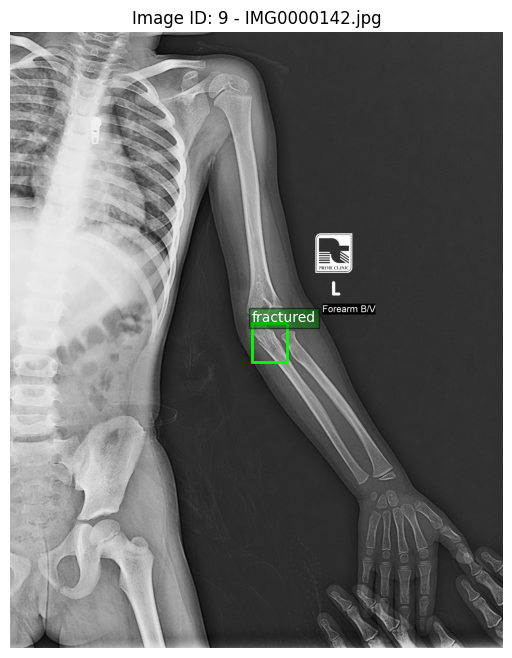

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# ---------------------------------------------------------------------
# 1. Set Paths
# ---------------------------------------------------------------------
file_path = "/content/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json"
images_folder = "/content/FracAtlas/images/Fractured"

# ---------------------------------------------------------------------
# 2. Load COCO Data
# ---------------------------------------------------------------------
with open(file_path, "r") as file:
    coco_data = json.load(file)

images_df = pd.DataFrame(coco_data.get("images", []))
annotations_df = pd.DataFrame(coco_data.get("annotations", []))
categories_df = pd.DataFrame(coco_data.get("categories", []))


cat_id_to_name = dict(zip(categories_df["id"], categories_df["name"]))


def show_annotated_images(images_df, annotations_df, cat_id_to_name, images_folder, num_images=9):


    for idx in range(min(num_images, len(images_df))):
        image_row = images_df.iloc[idx]
        img_id = image_row["id"]
        filename = image_row["file_name"]
        img_path = os.path.join(images_folder, filename)


        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not load image: {img_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        image_annotations = annotations_df[annotations_df["image_id"] == img_id]


        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(image)


        for _, ann_row in image_annotations.iterrows():
            x, y, w, h = ann_row["bbox"]
            rect = patches.Rectangle(
                (x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none'
            )
            ax.add_patch(rect)


            cat_id = ann_row["category_id"]
            cat_name = cat_id_to_name.get(cat_id, str(cat_id))
            ax.text(
                x, y - 5,
                cat_name,
                fontsize=10, color='white',
                bbox=dict(facecolor='green', alpha=0.5, pad=2)
            )

        ax.set_title(f"Image ID: {img_id} - {filename}")
        plt.axis('off')
        plt.show()

show_annotated_images(images_df, annotations_df, cat_id_to_name, images_folder, num_images=9)



image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000142.jpg: 1280x1024 1 fracture, 869.4ms
Speed: 35.5ms preprocess, 869.4ms inference, 28.0ms postprocess per image at shape (1, 3, 1280, 1024)


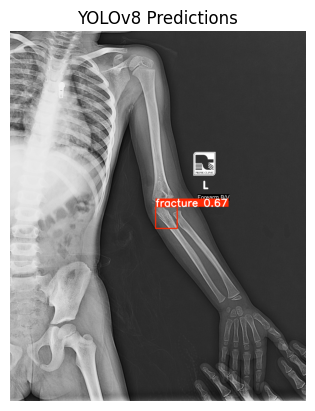

In [ ]:
import matplotlib.pyplot as plt
from ultralytics import YOLO


model_path = "/content/drive/MyDrive/Colab Notebooks/runs/detect/yolov8n_50e/weights/best.pt"
image_path = "/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000142.jpg"

model = YOLO(model_path)


results = model(image_path, conf=0.2)


results_plotted = results[0].plot()

plt.imshow(results_plotted)
plt.axis('off')
plt.title("YOLOv8 Predictions")
plt.show()


In [ ]:
import os
import json
import pandas as pd
from ultralytics import YOLO
import cv2

# ---------------------------------------------------------------------
# 1. Set Paths
# ---------------------------------------------------------------------
file_path = "/content/drive/MyDrive/Colab Notebooks/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json"
images_folder = "/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured"
model_path = "/content/drive/MyDrive/Colab Notebooks/runs/detect/yolov8n_50e/weights/best.pt"

# ---------------------------------------------------------------------
# 2. Load COCO Data
# ---------------------------------------------------------------------
with open(file_path, "r") as file:
    coco_data = json.load(file)

images_df = pd.DataFrame(coco_data.get("images", []))
annotations_df = pd.DataFrame(coco_data.get("annotations", []))
categories_df = pd.DataFrame(coco_data.get("categories", []))

cat_id_to_name = dict(zip(categories_df["id"], categories_df["name"]))

# Load the YOLO model
model = YOLO(model_path)

# ---------------------------------------------------------------------
# 3. Helper Function: Calculate IoU
# ---------------------------------------------------------------------
def calculate_iou(boxA, boxB):
    """
    Calculate Intersection over Union (IoU) between two boxes.
    boxA, boxB: [x1, y1, x2, y2]
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the areas of both boxes
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute IoU
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# ---------------------------------------------------------------------
# 4. Function: Calculate IoU for All Images
# ---------------------------------------------------------------------
def calculate_iou_for_all_images(
    images_df, annotations_df, cat_id_to_name, images_folder, model
):
    iou_results = []  # To store IoU results

    for _, image_row in images_df.iterrows():
        img_id = image_row["id"]
        filename = image_row["file_name"]
        img_path = os.path.join(images_folder, filename)

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not load image: {img_path}")
            continue

        # Get ground truth annotations for the image
        image_annotations = annotations_df[annotations_df["image_id"] == img_id]

        # Get predictions from the YOLO model
        results = model(img_path, conf=0.3)
        predictions = results[0].boxes  # Get the Boxes object

        # Process predictions and ground truth
        if predictions is not None and len(predictions) > 0:
            for pred in predictions:
                x1, y1, x2, y2 = pred.xyxy[0].cpu().numpy()  # Bounding box coordinates
                conf = pred.conf[0].cpu().item()            # Confidence score
                cls = pred.cls[0].cpu().item()              # Class ID

                pred_box = [x1, y1, x2, y2]
                pred_class_name = model.names[int(cls)]

                # Compare with all ground truth boxes
                for _, ann_row in image_annotations.iterrows():
                    gt_x, gt_y, gt_w, gt_h = ann_row["bbox"]
                    gt_box = [gt_x, gt_y, gt_x + gt_w, gt_y + gt_h]
                    gt_class_name = cat_id_to_name.get(ann_row["category_id"], "Unknown")

                    # Calculate IoU
                    iou = calculate_iou(gt_box, pred_box)

                    # Append result
                    iou_results.append({
                        "image_id": img_id,
                        "image_name": filename,
                        "gt_box": gt_box,
                        "gt_class": gt_class_name,
                        "pred_box": pred_box,
                        "pred_class": pred_class_name,
                        "confidence": conf,
                        "iou": iou
                    })

    # Convert results to DataFrame
    iou_df = pd.DataFrame(iou_results)
    return iou_df

# ---------------------------------------------------------------------
# 5. Run the Function and Save Results
# ---------------------------------------------------------------------
iou_df = calculate_iou_for_all_images(
    images_df, annotations_df, cat_id_to_name, images_folder, model
)

# Save results to a CSV file
output_csv_path = "/content/iou_results.csv"
iou_df.to_csv(output_csv_path, index=False)
print(f"IoU results saved to {output_csv_path}")


# Display the IoU DataFrame
print(iou_df)







image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000019.jpg: 1280x1024 1 fracture, 645.8ms
Speed: 14.5ms preprocess, 645.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1024)

image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000025.jpg: 1024x1280 2 fractures, 723.4ms
Speed: 13.5ms preprocess, 723.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1280)

image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000044.jpg: 1280x1024 (no detections), 630.0ms
Speed: 13.7ms preprocess, 630.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1024)

image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000057.jpg: 1280x1024 1 fracture, 655.3ms
Speed: 13.4ms preprocess, 655.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 1024)

image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000058.jpg: 1280x

In [ ]:
mean_iou = iou_df["iou"].mean()
print(f"Mean IoU across all images: {mean_iou:.4f}")

Mean IoU across all images: 0.5002


Prediction vs Ground Truth (Images)


image 1/1 /content/FracAtlas/images/Fractured/IMG0000019.jpg: 1280x1024 1 fracture, 15.6ms
Speed: 9.7ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1024)


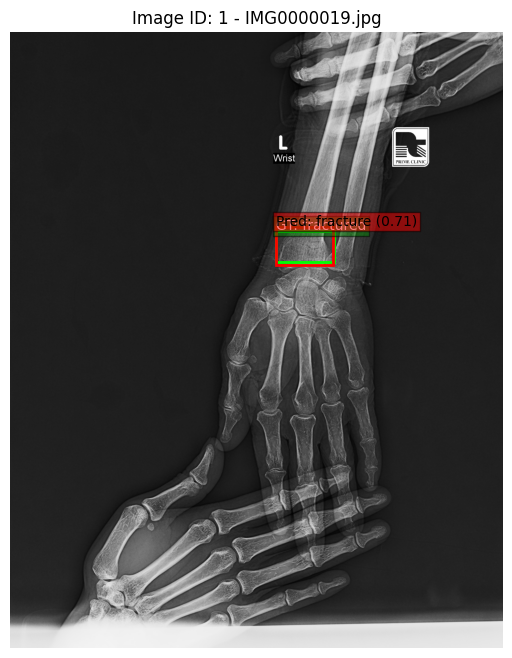


image 1/1 /content/FracAtlas/images/Fractured/IMG0000025.jpg: 1024x1280 1 fracture, 16.3ms
Speed: 15.8ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1280)


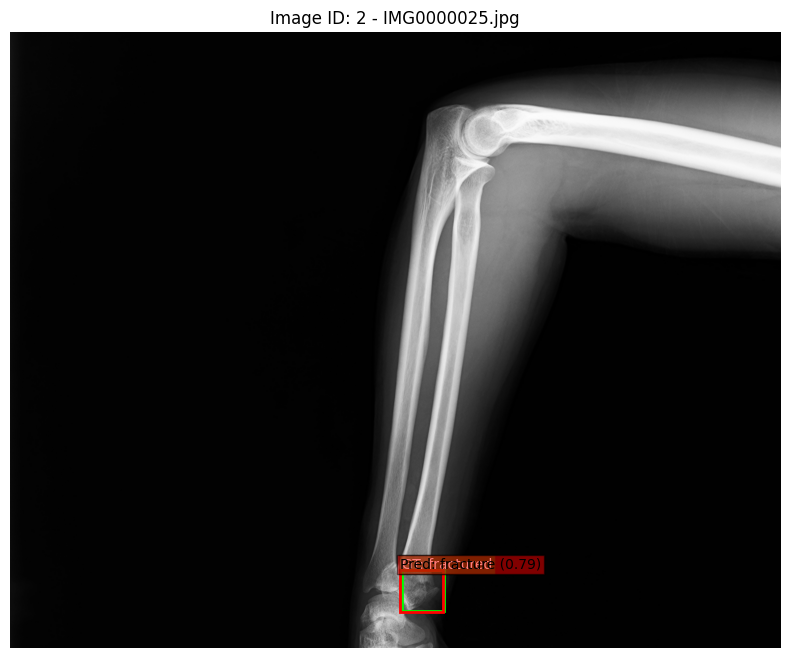


image 1/1 /content/FracAtlas/images/Fractured/IMG0000044.jpg: 1280x1024 (no detections), 15.9ms
Speed: 16.0ms preprocess, 15.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1024)


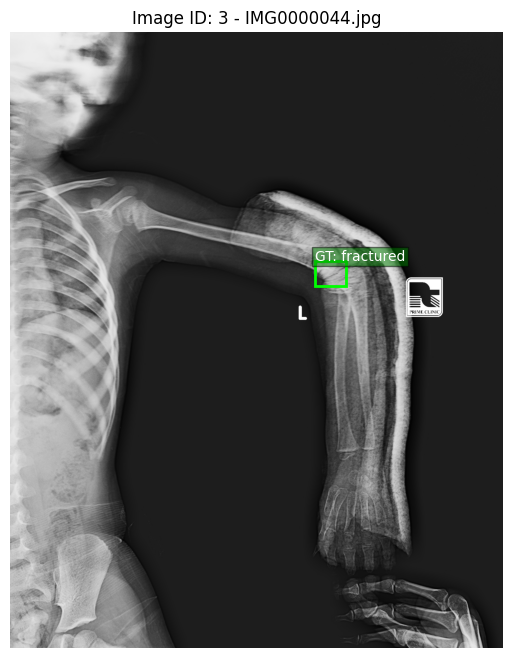


image 1/1 /content/FracAtlas/images/Fractured/IMG0000057.jpg: 1280x1024 1 fracture, 15.2ms
Speed: 16.5ms preprocess, 15.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1280, 1024)


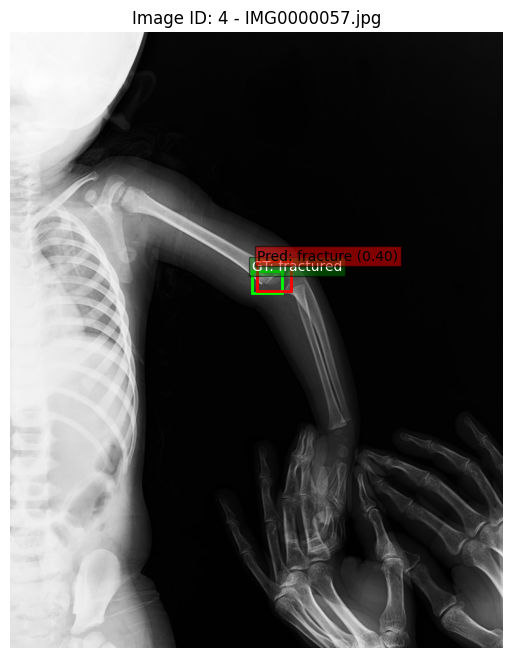


image 1/1 /content/FracAtlas/images/Fractured/IMG0000058.jpg: 1280x1024 1 fracture, 15.2ms
Speed: 15.8ms preprocess, 15.2ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1024)


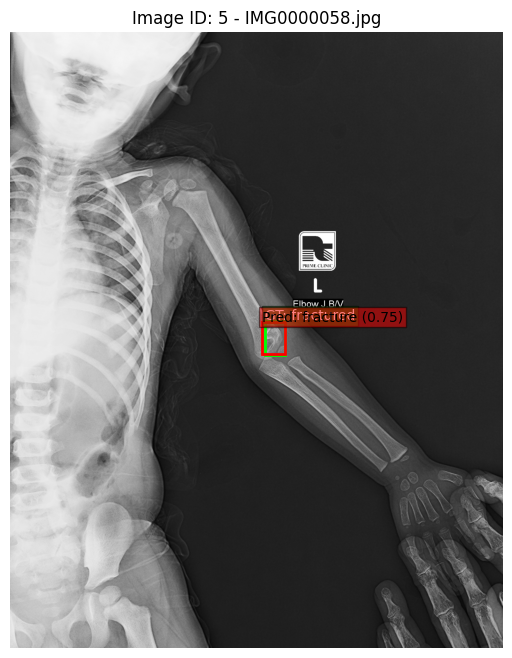


image 1/1 /content/FracAtlas/images/Fractured/IMG0000059.jpg: 1280x1024 (no detections), 15.1ms
Speed: 9.7ms preprocess, 15.1ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1024)


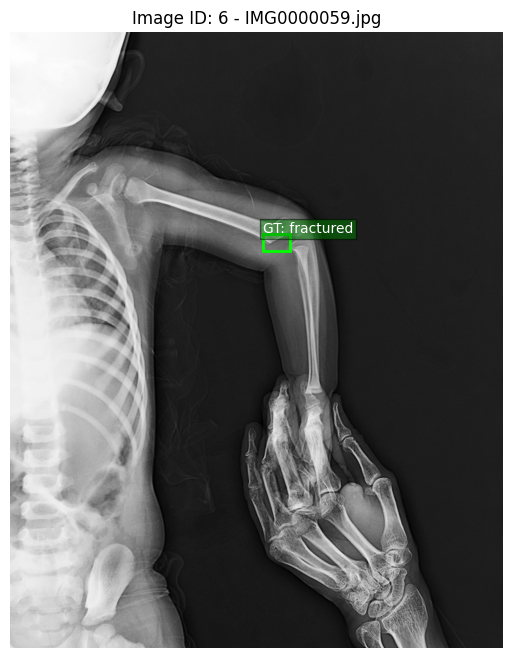


image 1/1 /content/FracAtlas/images/Fractured/IMG0000092.jpg: 1280x1024 (no detections), 15.1ms
Speed: 9.5ms preprocess, 15.1ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1024)


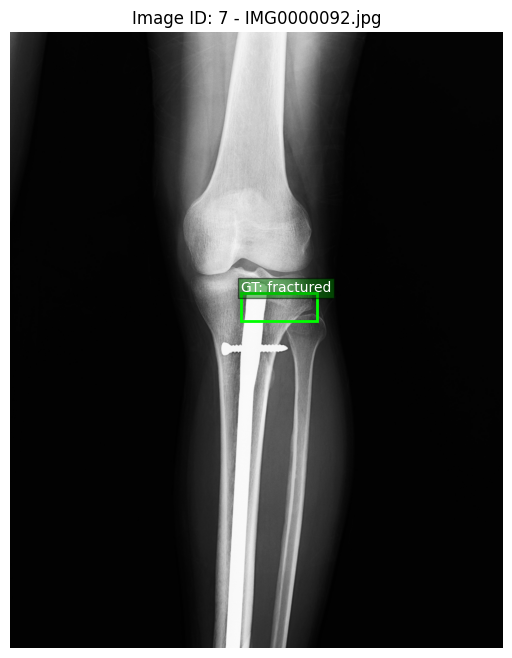


image 1/1 /content/FracAtlas/images/Fractured/IMG0000100.jpg: 1280x1024 1 fracture, 15.1ms
Speed: 9.7ms preprocess, 15.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1024)


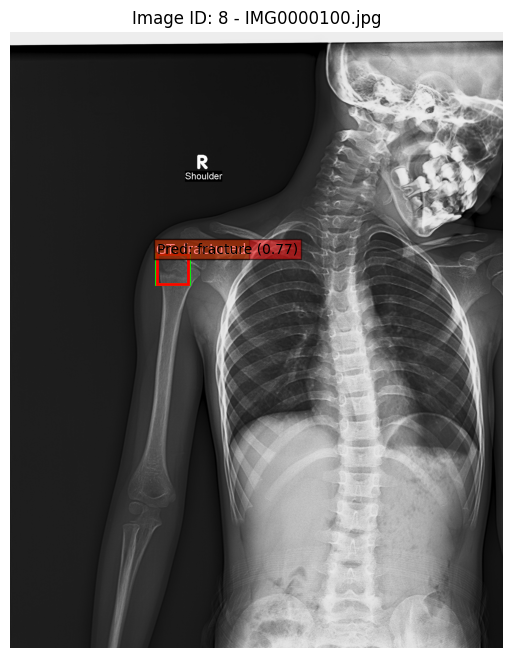


image 1/1 /content/FracAtlas/images/Fractured/IMG0000142.jpg: 1280x1024 (no detections), 15.1ms
Speed: 9.5ms preprocess, 15.1ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1024)


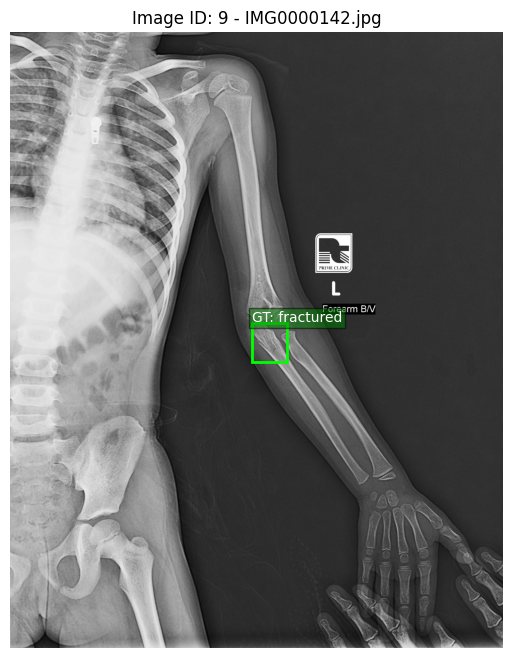

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from ultralytics import YOLO

# ---------------------------------------------------------------------
# 1. Set Paths
# ---------------------------------------------------------------------
file_path = "/content/drive/MyDrive/Colab Notebooks/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json"
images_folder = "/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured"
model_path = "/content/drive/MyDrive/Colab Notebooks/runs/detect/yolov8n_50e/weights/best.pt"

# ---------------------------------------------------------------------
# 2. Load COCO Data
# ---------------------------------------------------------------------
with open(file_path, "r") as file:
    coco_data = json.load(file)

images_df = pd.DataFrame(coco_data.get("images", []))
annotations_df = pd.DataFrame(coco_data.get("annotations", []))
categories_df = pd.DataFrame(coco_data.get("categories", []))

cat_id_to_name = dict(zip(categories_df["id"], categories_df["name"]))

# Load the trained YOLO model
model = YOLO(model_path)

# ---------------------------------------------------------------------
# 3. Function: Show Ground Truth and Predictions
# ---------------------------------------------------------------------
def show_annotated_images_with_predictions(
    images_df, annotations_df, cat_id_to_name, images_folder, model, num_images=9
):
    for idx in range(min(num_images, len(images_df))):
        image_row = images_df.iloc[idx]
        img_id = image_row["id"]
        filename = image_row["file_name"]
        img_path = os.path.join(images_folder, filename)

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not load image: {img_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get ground truth annotations
        image_annotations = annotations_df[annotations_df["image_id"] == img_id]

        # Get predictions from the model
        results = model(img_path, conf=0.3)
        predictions = results[0].boxes  # Get the Boxes object

        # Plot the image
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(image)

        # Overlay ground truth annotations (lime boxes)
        for _, ann_row in image_annotations.iterrows():
            x, y, w, h = ann_row["bbox"]
            rect = patches.Rectangle(
                (x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none'
            )
            ax.add_patch(rect)

            cat_id = ann_row["category_id"]
            cat_name = cat_id_to_name.get(cat_id, str(cat_id))
            ax.text(
                x, y - 5,
                f"GT: {cat_name}",
                fontsize=10, color='white',
                bbox=dict(facecolor='green', alpha=0.5, pad=2)
            )

        # Overlay predictions (red boxes)
        if predictions is not None and len(predictions) > 0:
            for pred in predictions:
                x1, y1, x2, y2 = pred.xyxy[0].cpu().numpy()  # Bounding box coordinates
                conf = pred.conf[0].cpu().item()            # Confidence score
                cls = pred.cls[0].cpu().item()              # Class ID
                rect = patches.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none'
                )
                ax.add_patch(rect)
                class_name = model.names[int(cls)]
                ax.text(
                    x1, y1 - 5,
                    f"Pred: {class_name} ({conf:.2f})",
                    fontsize=10, color='black',
                    bbox=dict(facecolor='red', alpha=0.5, pad=2)
                )

        # Set plot title and hide axis
        ax.set_title(f"Image ID: {img_id} - {filename}")
        plt.axis('off')
        plt.show()

# ---------------------------------------------------------------------
# 4. Run the Function
# ---------------------------------------------------------------------
show_annotated_images_with_predictions(
    images_df, annotations_df, cat_id_to_name, images_folder, model, num_images=9
)


Yolo11n Training

In [ ]:
!yolo \
task =detect \
mode =train \
model =yolo11n.pt \
imgsz ={IMG_SIZE} \
data =datafrac_v8.yaml \
epochs = {EPOCHS} \
batch ={BATCH} \
name = yolov8n_50ef


Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=datafrac_v8.yaml, epochs=80, time=None, patience=100, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_50ef, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr


image 1/1 /content/FracAtlas/images/Fractured/IMG0000142.jpg: 1280x1024 1 fracture, 16.6ms
Speed: 11.0ms preprocess, 16.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1024)


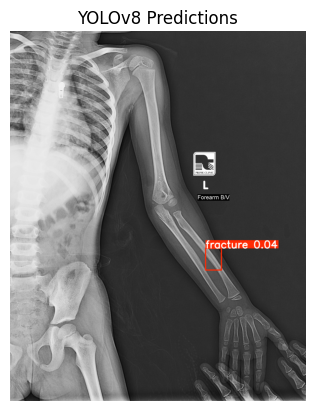

In [ ]:
import matplotlib.pyplot as plt
from ultralytics import YOLO


model_path = "/content/drive/MyDrive/Colab Notebooks/FracAtlas/runs/detect/yolov8n_50ef/weights/best.pt"
image_path = "/content/FracAtlas/images/Fractured/IMG0000142.jpg"


model = YOLO(model_path)


results = model(image_path, conf=0.035)


results_plotted = results[0].plot()

plt.imshow(results_plotted)
plt.axis('off')
plt.title("YOLOv8 Predictions")
plt.show()



image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000019.jpg: 1280x1024 (no detections), 16.5ms
Speed: 9.7ms preprocess, 16.5ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1024)


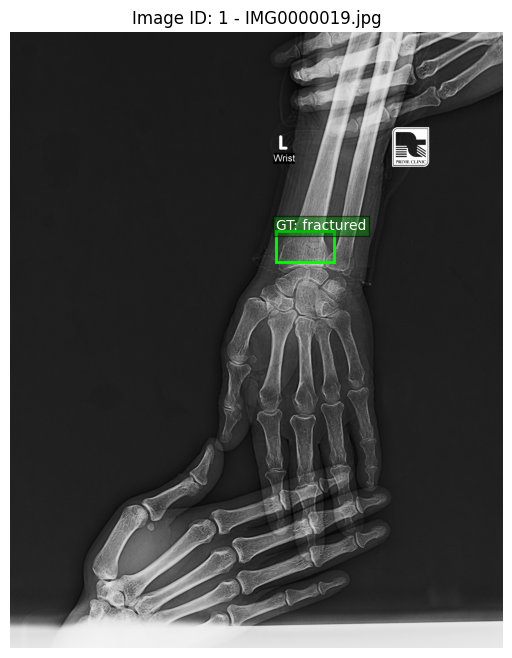


image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000025.jpg: 1024x1280 1 fracture, 62.9ms
Speed: 16.1ms preprocess, 62.9ms inference, 846.8ms postprocess per image at shape (1, 3, 1024, 1280)


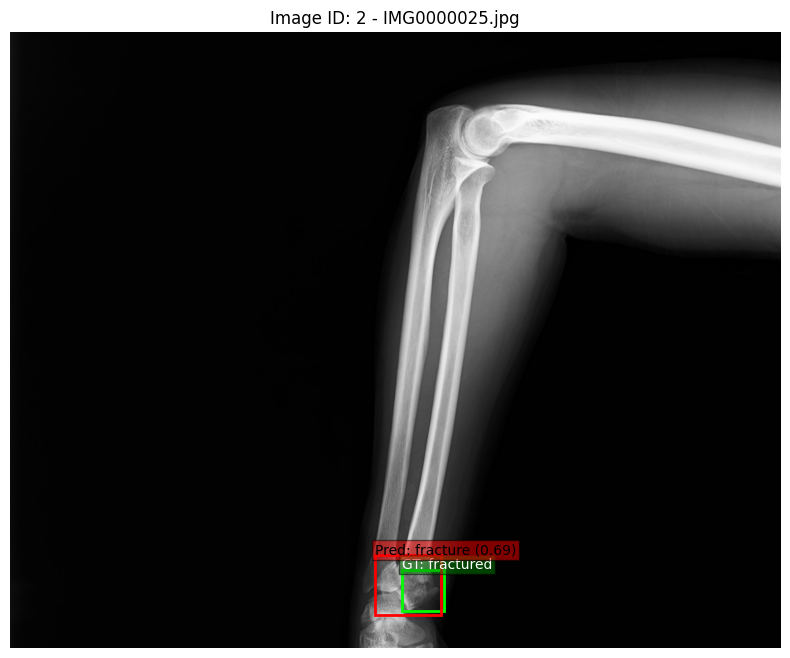


image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000044.jpg: 1280x1024 (no detections), 16.6ms
Speed: 9.6ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 1280, 1024)


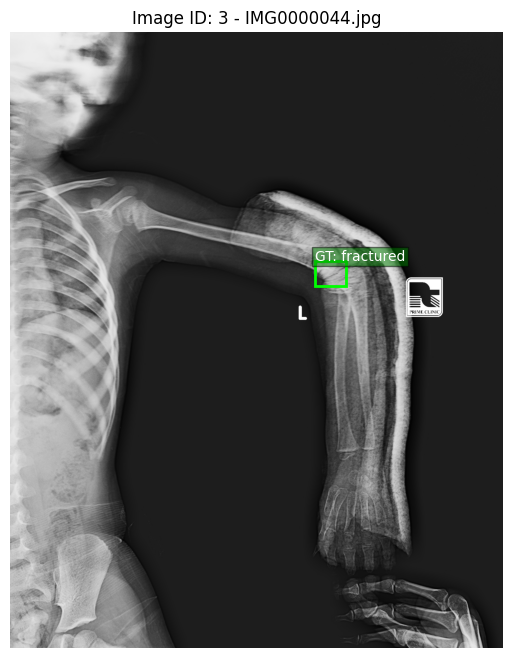


image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000057.jpg: 1280x1024 (no detections), 16.1ms
Speed: 9.9ms preprocess, 16.1ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1024)


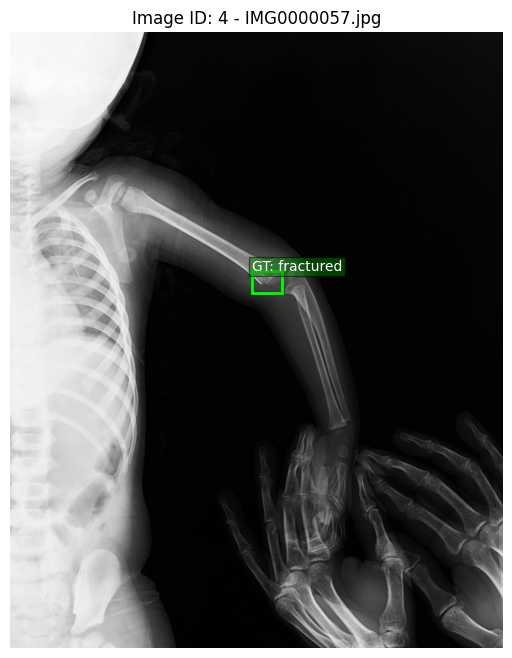


image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000058.jpg: 1280x1024 1 fracture, 16.1ms
Speed: 9.7ms preprocess, 16.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1024)


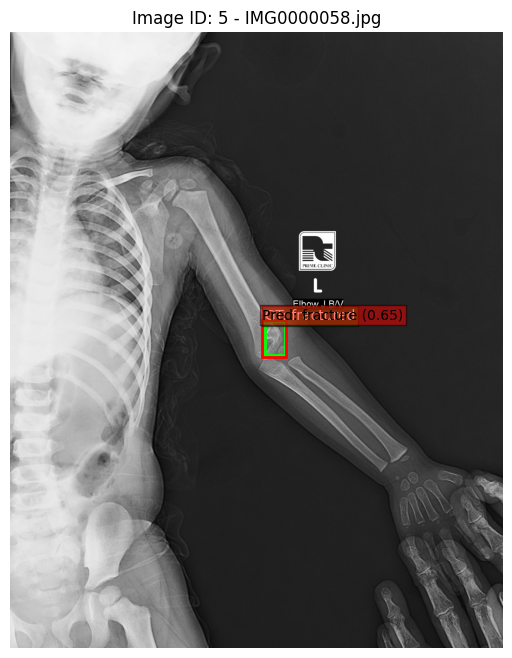


image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000059.jpg: 1280x1024 1 fracture, 16.1ms
Speed: 14.1ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1024)


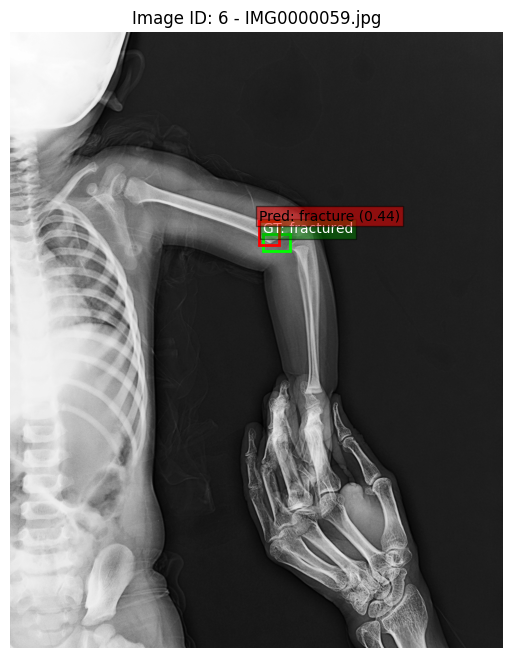


image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000092.jpg: 1280x1024 (no detections), 16.1ms
Speed: 9.7ms preprocess, 16.1ms inference, 0.6ms postprocess per image at shape (1, 3, 1280, 1024)


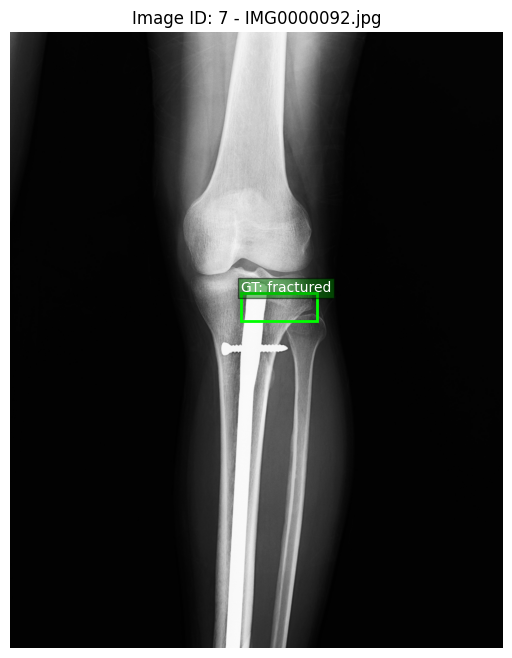


image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000100.jpg: 1280x1024 1 fracture, 16.1ms
Speed: 11.3ms preprocess, 16.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1280, 1024)


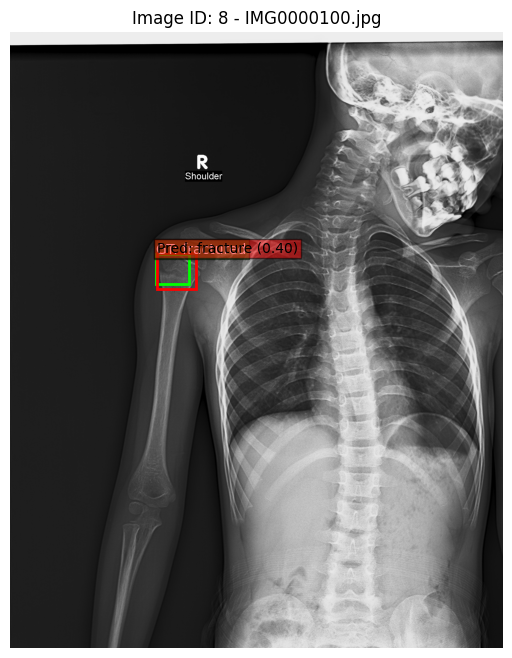


image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000142.jpg: 1280x1024 (no detections), 16.1ms
Speed: 16.9ms preprocess, 16.1ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1024)


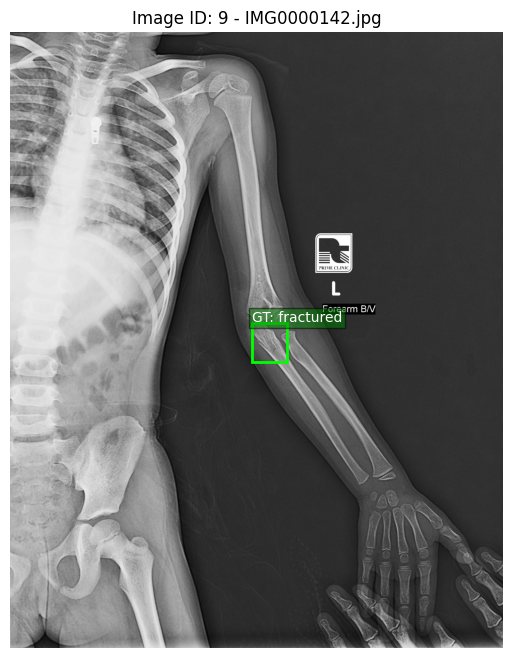

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from ultralytics import YOLO

# ---------------------------------------------------------------------
# 1. Set Paths
# ---------------------------------------------------------------------
file_path = "/content/drive/MyDrive/Colab Notebooks/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json"
images_folder = "/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured"
model_path = "/content/drive/MyDrive/Colab Notebooks/FracAtlas/runs/detect/yolov8n_50ef/weights/best.pt"

# ---------------------------------------------------------------------
# 2. Load COCO Data
# ---------------------------------------------------------------------
with open(file_path, "r") as file:
    coco_data = json.load(file)

images_df = pd.DataFrame(coco_data.get("images", []))
annotations_df = pd.DataFrame(coco_data.get("annotations", []))
categories_df = pd.DataFrame(coco_data.get("categories", []))

cat_id_to_name = dict(zip(categories_df["id"], categories_df["name"]))

# Load the trained YOLO model
model = YOLO(model_path)

# ---------------------------------------------------------------------
# 3. Function: Show Ground Truth and Predictions
# ---------------------------------------------------------------------
def show_annotated_images_with_predictions(
    images_df, annotations_df, cat_id_to_name, images_folder, model, num_images=9
):
    for idx in range(min(num_images, len(images_df))):
        image_row = images_df.iloc[idx]
        img_id = image_row["id"]
        filename = image_row["file_name"]
        img_path = os.path.join(images_folder, filename)

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not load image: {img_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get ground truth annotations
        image_annotations = annotations_df[annotations_df["image_id"] == img_id]

        # Get predictions from the model
        results = model(img_path, conf=0.3)
        predictions = results[0].boxes  # Get the Boxes object

        # Plot the image
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(image)

        # Overlay ground truth annotations (lime boxes)
        for _, ann_row in image_annotations.iterrows():
            x, y, w, h = ann_row["bbox"]
            rect = patches.Rectangle(
                (x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none'
            )
            ax.add_patch(rect)

            cat_id = ann_row["category_id"]
            cat_name = cat_id_to_name.get(cat_id, str(cat_id))
            ax.text(
                x, y - 5,
                f"GT: {cat_name}",
                fontsize=10, color='white',
                bbox=dict(facecolor='green', alpha=0.5, pad=2)
            )

        # Overlay predictions (red boxes)
        if predictions is not None and len(predictions) > 0:
            for pred in predictions:
                x1, y1, x2, y2 = pred.xyxy[0].cpu().numpy()  # Bounding box coordinates
                conf = pred.conf[0].cpu().item()            # Confidence score
                cls = pred.cls[0].cpu().item()              # Class ID
                rect = patches.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none'
                )
                ax.add_patch(rect)
                class_name = model.names[int(cls)]
                ax.text(
                    x1, y1 - 5,
                    f"Pred: {class_name} ({conf:.2f})",
                    fontsize=10, color='black',
                    bbox=dict(facecolor='red', alpha=0.5, pad=2)
                )

        # Set plot title and hide axis
        ax.set_title(f"Image ID: {img_id} - {filename}")
        plt.axis('off')
        plt.show()

# ---------------------------------------------------------------------
# 4. Run the Function
# ---------------------------------------------------------------------
show_annotated_images_with_predictions(
    images_df, annotations_df, cat_id_to_name, images_folder, model, num_images=9
)


In [ ]:
import os
import json
import pandas as pd
from ultralytics import YOLO
import cv2

# ---------------------------------------------------------------------
# 1. Set Paths
# ---------------------------------------------------------------------
file_path = "/content/drive/MyDrive/Colab Notebooks/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json"
images_folder = "/content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured"
model_path = "/content/drive/MyDrive/runs/detect/yolov8n_50ef/weights/best.pt"

# ---------------------------------------------------------------------
# 2. Load COCO Data
# ---------------------------------------------------------------------
with open(file_path, "r") as file:
    coco_data = json.load(file)

images_df = pd.DataFrame(coco_data.get("images", []))
annotations_df = pd.DataFrame(coco_data.get("annotations", []))
categories_df = pd.DataFrame(coco_data.get("categories", []))

cat_id_to_name = dict(zip(categories_df["id"], categories_df["name"]))

# Load the YOLO model
model = YOLO(model_path)

# ---------------------------------------------------------------------
# 3. Helper Function: Calculate IoU
# ---------------------------------------------------------------------
def calculate_iou(boxA, boxB):
    """
    Calculate Intersection over Union (IoU) between two boxes.
    boxA, boxB: [x1, y1, x2, y2]
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the areas of both boxes
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute IoU
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# ---------------------------------------------------------------------
# 4. Function: Calculate IoU for All Images
# ---------------------------------------------------------------------
def calculate_iou_for_all_images(
    images_df, annotations_df, cat_id_to_name, images_folder, model
):
    iou_results = []  # To store IoU results

    for _, image_row in images_df.iterrows():
        img_id = image_row["id"]
        filename = image_row["file_name"]
        img_path = os.path.join(images_folder, filename)

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not load image: {img_path}")
            continue

        # Get ground truth annotations for the image
        image_annotations = annotations_df[annotations_df["image_id"] == img_id]

        # Get predictions from the YOLO model
        results = model(img_path, conf=0.3)
        predictions = results[0].boxes  # Get the Boxes object

        # Process predictions and ground truth
        if predictions is not None and len(predictions) > 0:
            for pred in predictions:
                x1, y1, x2, y2 = pred.xyxy[0].cpu().numpy()  # Bounding box coordinates
                conf = pred.conf[0].cpu().item()            # Confidence score
                cls = pred.cls[0].cpu().item()              # Class ID

                pred_box = [x1, y1, x2, y2]
                pred_class_name = model.names[int(cls)]

                # Compare with all ground truth boxes
                for _, ann_row in image_annotations.iterrows():
                    gt_x, gt_y, gt_w, gt_h = ann_row["bbox"]
                    gt_box = [gt_x, gt_y, gt_x + gt_w, gt_y + gt_h]
                    gt_class_name = cat_id_to_name.get(ann_row["category_id"], "Unknown")

                    # Calculate IoU
                    iou = calculate_iou(gt_box, pred_box)

                    # Append result
                    iou_results.append({
                        "image_id": img_id,
                        "image_name": filename,
                        "gt_box": gt_box,
                        "gt_class": gt_class_name,
                        "pred_box": pred_box,
                        "pred_class": pred_class_name,
                        "confidence": conf,
                        "iou": iou
                    })

    # Convert results to DataFrame
    iou_df = pd.DataFrame(iou_results)
    return iou_df

# ---------------------------------------------------------------------
# 5. Run the Function and Save Results
# ---------------------------------------------------------------------
iou_df = calculate_iou_for_all_images(
    images_df, annotations_df, cat_id_to_name, images_folder, model
)

# Save results to a CSV file
output_csv_path = "/content/iou_results.csv"
iou_df.to_csv(output_csv_path, index=False)
print(f"IoU results saved to {output_csv_path}")


# Display the IoU DataFrame
print(iou_df)







image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000019.jpg: 1280x1024 1 fracture, 699.8ms
Speed: 14.1ms preprocess, 699.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1024)

image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000025.jpg: 1024x1280 (no detections), 621.3ms
Speed: 14.3ms preprocess, 621.3ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1280)

image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000044.jpg: 1280x1024 (no detections), 637.2ms
Speed: 18.1ms preprocess, 637.2ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1024)

image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000057.jpg: 1280x1024 (no detections), 636.8ms
Speed: 14.2ms preprocess, 636.8ms inference, 0.7ms postprocess per image at shape (1, 3, 1280, 1024)

image 1/1 /content/drive/MyDrive/Colab Notebooks/FracAtlas/images/Fractured/IMG0000058.j

In [ ]:
mean_iou = iou_df["iou"].mean()
print(f"Mean IoU across all images: {mean_iou:.4f}")

Mean IoU across all images: 0.3871
